# Finding Roots of Nonlinear Equations

In this lecture we will study how to  to numerically solve the equation $f(x)=0$, where $f(x)$ is some function.  A solution $x$ that satisfies this equation is
known as a *root* of the equation.  Depending on the function $f(x)$, there could be no roots, one root, or multiple roots, and this immediately 
suggests that before you even start coding up this problem, you should investigate the behavior of the function so that you know what you are asking
the computer to do.  The best way of doing this is to simply plot the function using `matplotlib.pyplot`, so that you have an idea of how
many roots you might have, and approximately where they might be.  Having this information before attempting a solution is incredibly valuable.

Incidentally,  a closely related problem is to calculate the locations of minima, maxima, and points of inflection of a function, i.e the roots of
$f^\prime(x)=0$.  This can also be done using the methods we will explore here.

There are a variety of different numerical methods that you can use to find roots, and choosing between them depends on how much knowledge you have about the root, the functional behavior near the root, and whether or not you can compute the derivative of the function.  Some algorithms are more efficient than others, for *most* usage cases, but they can also fail sometimes.  Again, the more knowledge you have of the function's behavior, the better off you will be.

## Kepler's Equation
As a first example, consider a famous historical example of a transcendental equation in physics and astronomy:
$$
M=E-e\sin E
$$
which is known as *Kepler's equation*, and concerns planets on eccentric orbits around the sun, where the eccentricity $e$ lies between 0 (circular
orbit) and 1 (parabolic orbit).  The historical problem<sup id="a1">[1](#f1)</sup> was to calculate $E$ (the so-called eccentric anomaly) given a value of $M$ (the so-called mean anomaly).  There is no exact closed-form analytic solution, although there are solutions that can be expressed in terms of infinite series of special functions - not very practical!


Let us try and solve this equation for $E$ when $M=1$ radian and eccentricity $e=0.4$.   Before we try to solve for the roots, we should plot the function to better undersand what we are dealing with. Rearranging
to the form $f(x)=0$ we get:
$$ 
E-e\sin E-M = 0
$$
and define this to be the function:

In [2]:
import numpy as np
def kepler(E, M=1.0, e=0.4):
    """
    Kepler's equation function for root finding. 

    Parameters
    ----------
    E : float or array_like
        Eccentric anomaly in radians. 
    M : float or array_like, optional
        Mean anomaly in radians. The default is 1.0.
    e : float or array_like, optional
        Eccentricity (dimensionless). The default is 0.4.

    Returns
    -------
    keplers_eq : float or array_like
        Result of Kepler's equation in radians. 
    """

    return E - e*np.sin(E) - M

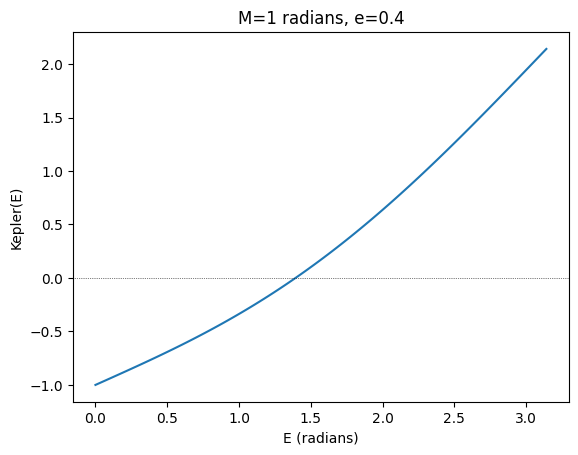

In [3]:
import matplotlib.pyplot as plt
E = np.linspace(0, np.pi, 100)
kepler_eq = kepler(E)
plt.plot(E, kepler_eq)
plt.xlabel('E (radians)')
plt.ylabel('Kepler(E)')
plt.title('M=1 radians, e=0.4')
plt.axhline(0, color='black', linestyle=':', lw=0.5)

Evidently there is a single root at around $E\approx 1.4$ radians. Let us know explore two different methods to find it. 

## Bracketing and Bisection

In cases where $f(x)=0$ and $f^\prime(x)\ne0$, the function will have opposite signs on either side of the root.  In this case we can **bracket** the root
by saying it must lie somewhere between a value $x=a$ where $f(a)$ has one sign, and a value $x=b$ where $f(b)$ has the opposite sign.  For such cases
there is a very simple method of finding the root known as **bisection**. It is generally rather inefficent, but unlike some other methods (including
the next one), it is **guaranteed** to work.

The idea is very simple.  Just divide the interval $a<x<b$ evenly in two, and check the sign of the function at the midpoint:  $f((a+b)/2)$.  The sign
of the function there then tells you in which half the root lies, so you have produced a tighter bracket.  Then just iterate the same procedure 
until your bracket achieves your desired level of accuracy. 

The code below provides an example implementation:

In [5]:
def bisection(func, a, b, tol=1e-4, max_iter=100, verbose=False):
    """
    Find a root x of the equation func(x)=0 within an interval [a, b] using the bisection method.

    Parameters
    ----------
    func : callable
        The function for which to find the root. 
    a : float
        The lower bound of the interval.
    b : float
        The upper bound of the interval.
    tol : float, optional
        The absolute tolerance for the root. The function returns when the size of the bisection interval is less than tol. Default is 1e-4. 
    max_iter : int, optional
        The maximum number of iterations. Default is 100.

    Returns
    -------
    root: float
        The root of the function.

    Raises
    ------
    ValueError
        If a is not less than b.
    ValueError
        If f(a) and f(b) have the same sign.
    ValueError
        If the function does not converge within max_iter iterations.
    """
    # Do some error checking
    if not a < b:
        raise ValueError("a must be less than b")
    if func(a) * func(b) > 0:
        raise ValueError("f(a) and f(b) must have different signs")

    for iter in range(max_iter):
        # bisect, x is the new candidate root
        x = (a + b) / 2
        if verbose:
            # Print the current values of a, root, and b
            print(f"iteration: {iter + 1:3d}, a: {a:.6f}, root: {x:.6f}, b: {b:.6f}, eps: {(b - a)/2:.6f}")
        # Check if we found the zero or if the localization interval (b-a)/2 = (x-a) = (b-x) 
        # is within the tolerance.
        if func(x) == 0.0 or (b - a)/2 < tol:
            break
        # If the signs of f(x) and f(a) are different then the root is between a and x, update b
        if func(x) * func(a) < 0:
            b = x
        # Otherwise if the sign of f(a) and f(x) are the same, the root is between x and b, update a
        else:
            a = x
    else:
        # If the loop completes without a break, enter the else and raise an error.
        raise ValueError(f"The localization interval = {b-a/2} > {tol} = tolerance after max_iter = {max_iter} iterations\n" + 
                         f"Increase the value of max_iter. ")
    return x

Since the bracket interval decreases by a factor of two on every iteration, then after $n$ iterations, the original interval $\epsilon_0=b-a$ will be reduced to 
$$
\epsilon_n=2^{-n}\epsilon_0,  
$$
where $\epsilon_n$ is the width of the bracket at the $n$ th iteration.  In other words, achieving a tolerance of $\epsilon_n$ requires 
$$
 n = \ln(\epsilon_0/\epsilon_n)/\ln2, 
$$
iterations, and the better your initial guess for the root, $\epsilon_0$, the fewer iterations required. Because $\epsilon_{n+1}$ is simply proportional to $\epsilon_n$
$$
\epsilon_{n+1} = \epsilon_n/2, 
$$
the bisection method is said to converge linearly. 


Let's run on Kepler's equation in verbose mode and print the results to the screen:

In [6]:
# By eye the root was around 1.4 so we choose the values of a and b accordingly
a = 1.25
b = 1.5

root = bisection(kepler, a, b, verbose=True)


iteration:   1, a: 1.250000, root: 1.375000, b: 1.500000, eps: 0.125000
iteration:   2, a: 1.375000, root: 1.437500, b: 1.500000, eps: 0.062500
iteration:   3, a: 1.375000, root: 1.406250, b: 1.437500, eps: 0.031250
iteration:   4, a: 1.375000, root: 1.390625, b: 1.406250, eps: 0.015625
iteration:   5, a: 1.390625, root: 1.398438, b: 1.406250, eps: 0.007812
iteration:   6, a: 1.390625, root: 1.394531, b: 1.398438, eps: 0.003906
iteration:   7, a: 1.390625, root: 1.392578, b: 1.394531, eps: 0.001953
iteration:   8, a: 1.392578, root: 1.393555, b: 1.394531, eps: 0.000977
iteration:   9, a: 1.393555, root: 1.394043, b: 1.394531, eps: 0.000488
iteration:  10, a: 1.393555, root: 1.393799, b: 1.394043, eps: 0.000244
iteration:  11, a: 1.393555, root: 1.393677, b: 1.393799, eps: 0.000122
iteration:  12, a: 1.393677, root: 1.393738, b: 1.393799, eps: 0.000061


As expected, it took 12 iterations to achieve our tolerance of `tol=1e-4` or $\epsilon_n=10^{-4}$. Since $b=1.5$ and $a = 1.25$, 
$\epsilon_0 = b-a = 1.5-1.25 = 0.25$, and we have
$$
n = \ln({0.25/10^{−4}})/\ln 2 = 11.3, 
$$
so 12 iterations are required. With that number we achieve a tolerance of $0.25/2^{12} = 6.1 \times 10^{−5}$.

## The Newton-Raphson Method


This is a method that does not require that you bracket the root.  Instead, the idea is extremely simple: starting from an initial guessed value of the root $x_0$, Taylor expand your function to first (linear) order about this guess and set that Taylor expansion to zero to find a new guess for the root:
$$
f(x)=0\simeq f(x_0)+f^\prime(x_0)(x-x_0),
$$
which gives
$$
x=x_0-\frac{f(x_0)}{f^\prime(x_0)}.
$$
In other words, you approximate your function with a linear approximation, also known as the tangent line at your guessed value, and find where the tangent line intercepts the $x$-axis to
find a new guess for your root.  Then we just iterate:
$$
x_{n+1}=x_n-\frac{f(x_n)}{f^\prime(x_n)}.
$$

The disadvantage of this method is that if you ever happen to get near an extremum of your function, where $f^\prime(x_n)$ is close to zero, this
method will then take you very far away from where the root is likely to be. There are also situations where Newton-Raphson iterations can oscillate
about the root but not converge to it. Thus Newton-Raphson can fail or take a very long time to converge in some instances. 

On the other hand, when it works, Newton-Raphson converges much more rapidly than bisection, provided the
function is smooth and you are sufficiently close to the root. You can see this just by Taylor expanding the numerator and denominator of the
expression below:
$$
\begin{align*}
\epsilon_{n+1} & \equiv x_{n+1}-x_n = -\frac{f(x_n)}{f^\prime(x_n)} = -\frac{f(x_{n-1}+\epsilon_n)}{f^\prime(x_{n-1}+\epsilon_n)} \\
& = -\frac{f(x_{n-1})+\epsilon_nf^\prime(x_{n-1})+\frac{\epsilon_n^2}{2} f^{\prime\prime}(x_{n-1})+...}{f^\prime(x_{n-1})+\epsilon_n f^{\prime\prime}(x_{n-1}) + \frac{\epsilon_n^2}{2}f^{\prime\prime\prime}(x_{n-1})+ ...} = -\frac{\frac{\epsilon_n^2}{2} f^{\prime\prime}(x_{n-1})+...}{f^\prime(x_{n-1})+\epsilon_n f^{\prime\prime}(x_{n-1}) + \frac{\epsilon_n^2}{2}f^{\prime\prime\prime}(x_{n-1}) + ...}\\
& \simeq -\frac{\epsilon_n^2}{2}\frac{f^{\prime\prime}(x_{n-1})}{f^\prime(x_{n-1})}, 
\end{align*}
$$
where we used the Newton-Raphson formula in the second line, $f(x_{n-1})+\epsilon_nf^\prime(x_{n-1})=0$, to simplify the numerator, and for the approximation on the third line we assumed we were very close to the root, which means $\epsilon_n$ is a small number, and thus we kept only the leading order terms $\epsilon_n$. 

In contrast to bisection, where $\epsilon_{n+1}=\epsilon_n/2$ (linear in $\epsilon_n$), here $\epsilon_{n+1}$ is *quadratic* in $\epsilon_n$.
Thus provided we are close enough to the real root so that the equation above is valid (recall we assumed $\epsilon_n$ is small, which means that
successive guesses $x_n$ and $x_{n-1}$ are close to each other), Newton-Raphson will converge much faster than bisection!

Below we provide an example of a Newton-Raphson implementation:

In [9]:
def deriv(func, x, h=1e-4):
    """
    Compute the nth derivative of a function f(x) using the symmetric difference formula.

    Parameters
    ----------
    func : callable 
        Function to take the derivative of.
    x : float or array_like
        Location(s) at which to evaluate the derivative.
    h : float, optional
        Step size. The default is 1e-4.

    Returns
    -------
    df/dx(x): float or array_like
        The derivative of f(x) evaluated at x. shape is same as x. 

    """
    return (func(x + h) - func(x - h))/(2*h)


def newton_raphson(func, x0, fprime=None, tol=1e-4, h=1e-4, max_iter=100, verbose=False):
    """
    Find a root x of the equation func(x)=0 with derivative df(x) using the Newton-Raphson method.

    Parameters
    ----------
    func : callable
        The function for which to find the root.
    x0 : float
        The initial guess for the root.
    fprime : callable, optional 
        The derivative of the function. Default is None, in which case the derivative will be computed numerically.  
    tol : float, optional
        The absolute tolerance for the root. The function returns when the absolute value of the difference 
        between the current and previous root is less than tol. Default is 1e-5.
    h : float, optional
        Step size if the derivative is to be computed numerically. The default is 1e-4.
    max_iter : int, optional
        The maximum number of iterations. Default is 100.
    verbose : bool, optional
        If True, print the iteration process. Default is False.

    Returns
    -------
    float
        The root of the function.

    Raises
    ------
    ValueError
        If the function does not converge within max_iter iterations.
    """
    # Initialize the current guess for the root
    x = x0

    # Perform the Newton-Raphson iteration
    for iter in range(max_iter):
        # Calculate the function value and its derivative at the current guess
        f = func(x)
        # Use the analytical derivative function if provided, otherweise use the numerical derivative
        dfx = fprime(x) if fprime is not None else deriv(func, x, h=h)

        # Update the guess using the Newton-Raphson formula
        prev_x = x
        x = x - f/dfx

        if verbose:
            # Print the current iteration, root, and absolute difference between the current and previous root
            print(f"iteration: {iter + 1}, current root: {x:.12f}, previous root: {prev_x:.12f}, |difference|: {np.abs(x - prev_x):.12f}")

        # If the absolute difference between the current and previous root is less than the tolerance, the root has been found
        if func(x) == 0.0 or np.abs(x - prev_x) < tol:
            break 
    else: 
        # If the function did not break out after max_iter iterations we enter elese. Since it did not converge. Raise an exception. 
        raise ValueError(f"The absolute difference between the current and previous root = {abs(x - prev_x)} > {tol} = tolerance after max_iter = {max_iter} iterations\n" + 
                         f"Increase the value of max_iter or changing the initial guess.")
    
    return x

Notice that in the code above, a function `df` that computes the derivative of the `f(x)` is optional. If the function `df` is not provided, the code defaults to computing $f^\prime(x)$ numerically using the function `deriv`, which uses the symmetric difference derivative estimate that you studied in the homework.  Generally speaking, it is always better to provide the derivative function if it can be computed analytically, since this avoids extra floating point errors associated with taking numerical derivatives.  However, in a situation where an analytic closed form expression for the derivative of your function does not exist, a numerical derivative would be the way to go. Indeed, application of the Newton-Raphson algorithm with a numerically estimated derivative is closely related to the  **secant method**, which is a root-finding algorithm that is qualitatively similar to Newton-Raphson, but does not require the derivative of the function, since it estimates the derivative using a finite difference of the function over an interval which becomes smaller and smaller as the algorithm iterates.  Passing in the derivative function as an optional argument is analogous to the way the more sophisticated root-finding routines in `scipy.optimize` work, which we will come to next.

Below we provide examples of our Newton-Raphson implementation for both cases, i.e. with and without passing in an explicit derivative function. First, the function implementing the analytical derivative of the Kepler equation is

In [8]:
def kepler_prime(E, e=0.4):
    """
    Returns the derivative of Kepler's equation for the eccentric anomaly E. 

    Parameters
    ----------
    E : float or array_like
        Eccentric anomaly in radians. 
    e : float or array_like, optional
        Eccentricity (dimensionless). The default is 0.4.

    Returns
    -------
    keplers_eq_deriv : float or array_like
        Derivative of Kepler's equation with respect to E (dimensionless). 
    """

    return 1 - e*np.cos(E)

Here is the example passing in the derivative function explicitly:

In [10]:
E0 = 1.0
root = newton_raphson(kepler, E0, fprime=kepler_prime, verbose=True)

iteration: 1, current root: 1.429388158861, previous root: 1.000000000000, |difference|: 0.429388158861
iteration: 2, current root: 1.394013141009, previous root: 1.429388158861, |difference|: 0.035375017852
iteration: 3, current root: 1.393747086806, previous root: 1.394013141009, |difference|: 0.000266054203
iteration: 4, current root: 1.393747071814, previous root: 1.393747086806, |difference|: 0.000000014992


And now computing the derivative numerically

In [11]:
root_secant = newton_raphson(kepler, E0, verbose=True)

iteration: 1, current root: 1.429388158664, previous root: 1.000000000000, |difference|: 0.429388158664
iteration: 2, current root: 1.394013141010, previous root: 1.429388158664, |difference|: 0.035375017654
iteration: 3, current root: 1.393747086806, previous root: 1.394013141010, |difference|: 0.000266054204
iteration: 4, current root: 1.393747071814, previous root: 1.393747086806, |difference|: 0.000000014992


Even though we started further away from the answer $E_0 = 1.0$ than when we tried solving using bisection, Newton-Raphson converged to the same tolerance in just four iterations! This is the case whether or not we passed in the derivative function explicitly. But one sees that some of the numbers in the numerical derivative version differ slightly at the level of the 12th decimal place. 

## Root Finding Using Scipy or Numpy

The example codes provided in this notebook are here to introduce the basic ideas that underlie root-finding. However, in practice, you should use the root-finding routines provided in the `scipy.optimize` module, which are far more sophisticated and robust than the simple implementations we have provided here.  The `scipy.optimize` module provides a variety of different root-finding routines, including the bisection and Newton-Raphson methods we  discussed, as well as other more sophisticated methods that are extensions of these ideas. The `numpy` module also has a root-finding routine specifically designed for finding the roots of polynomials, which can be determined far more quickly and robustly using algorithms specifically designed for polynomial roots. 

In this lecture we only considered finding roots of one dimensional (univariate) functions $f(x)=0$, but sometimes we are interested in finding the multidimensional (multivariate) roots of a coupled system of equations, e.g. the values of $x$ and $y$ that simultaneously solve $f(x,y)=0$ and $g(x,y)=0$.  Or more generally in $N$ dimensions
$$
f_i(\mathbf{x})\equiv f_i(x_0,x_1,...,x_{N-1})=0,
$$
where the index $i$ can run from 0 to $N-1$, and both ${\bf f}$ and ${\bf x}$ are $N$-dimensional vectors.  This problem is famously difficult, in that there are *no* known algorithms that are guaranteed to work to find all the roots. Multidimensional Newton-Raphson is generally the workhorse here, but it can fail for similar reasons that it can fail in computing one-dimensional roots.   We will not discuss multivariate root-finding further, but it is worth noting that the generalization  of the derivative in one dimensional Newton-Raphson to the multidimensional case is the Jacobian matrix
$$
J_{ij}=\frac{\partial f_i}{\partial x_j},  
$$
which can either be provided as an input function (analogous to our `fprime` function in the one-dimensional case), or it can be estimated 
numerically in the `scipy.optimize` routines. 

For root-finding using `scipy` or `numpy` the same basic principles apply: 
1.  plot the function to get an idea of where the roots are, and what algorithm will be most appropriate 
2.  routines that require a bracket will always perform better if the interval is close to the root 
3.  if the algorithm requires derivative information, analytic derivatives are typically going to perform better than numerical derivatives. 

Below we provide a summary of the different root-finding routines available in `scipy.optimize` and `numpy`, along with some of the pros and cons of each method:

1. **`scipy.optimize.root`**
    - **Pros**: Can handle both univariate and multivariate functions. Supports several methods (Hybrid, LM, Broyden, etc.), and automatically chooses the best method if none is specified. Provides detailed output information.
    - **Cons**: Might be overkill for simple univariate functions. Some methods require the Jacobian matrix. 

2. **`scipy.optimize.newton`**
    - **Pros**: Fast convergence for functions that are well-behaved. Will fall back to the secant method if the derivative is not provided.
    - **Cons**: Requires the derivative of the function. Can fail to converge or converge to a non-root if the initial guess is not close to the root.

3. **`scipy.optimize.bisect`**
    - **Pros**: Guaranteed to converge if the function changes sign over an interval. Does not require the derivative of the function.
    - **Cons**: Slower convergence compared to methods like Newton or secant.

4. **`scipy.optimize.ridder`**
    - **Pros**: Faster convergence than bisection. Does not require the derivative of the function.
    - **Cons**: Requires the function to change sign over the specified interval.

5.  **`scipy.optimize.brentq` and `scipy.optimize.brenth`**
    - **Pros**: Combines bisection, secant, and so-called inverse quadratic interpolation. Generally considered a good choice for most numerical root-finding problems. Does not require the derivative of the function.
    - **Cons**: Requires the function to change sign over an interval.

6.  **`scipy.optimize.fsolve`**
    - **Pros**: Can handle both univariate and multivariate functions. Similar to `root` but provides a simpler interface for common use cases.
    - **Cons**: Might be less robust than `root`. Some methods require the Jacobian matrix. 

7. **`scipy.optimize.root_scalar`**
    - **Pros**: Provides a unified interface for several different root-finding methods, including bisection, Brent's method, Ridder's method, and secant method. Can handle univariate functions. Does not require the derivative of the function for some methods.
    - **Cons**: Requires the function to change sign over an interval for methods like bisection, Brent's method, and Ridder's method. For the secant method, requires a good initial guess to ensure convergence.
8. **`numpy.roots`**
    - **Pros**: Specifically designed for finding the roots of polynomials. Can find all roots of a polynomial, including complex roots.
    - **Cons**: Only works for polynomials. The accuracy of the roots can be affected by the numerical stability of the polynomial's coefficients.


Below is an example using the scipy.optimize.bisect function to solve Kepler's equation. I've intentionally set the absolute tolerance to be `1e-4` and the initial guess interval $a$ and $b$ to be identical to our example above: 

In [12]:
from scipy import optimize 
# Find the root using the bisect function
root_bisect, result_bisect = optimize.bisect(kepler, a, b, xtol=1e-4, full_output=True)

# Print the root
print(f"The root is {root_bisect:.8f}")


The root is 1.39373779


We can  check whether the root finding was successful and determine the number of function calls required via the returned `result` object

In [13]:
result_bisect

      converged: True
           flag: converged
 function_calls: 14
     iterations: 12
           root: 1.39373779296875
         method: bisect

For Newton-Raphson we can use the `scipy.optimize.newton`, again with parameters analogous to what we used above:

In [14]:
# Solve Kepler's equation using scipy.optimize.newton
root_newton, result_newton = optimize.newton(kepler, E0, tol=1e-4, fprime=kepler_prime, full_output=True)

# Print the root
print(f"The root is {root:.8f}")

The root is 1.39374707


In [15]:
result_newton

      converged: True
           flag: converged
 function_calls: 8
     iterations: 4
           root: 1.393747071813677
         method: newton

Finally, we could use `scipy.optimize.root_scalar` function (general univariate root finder) using **Brent's method** which combines bisection, the secant method, and inverse quadratic interpolation: 

In [16]:
result_root = optimize.root_scalar(kepler, bracket = (a,b), method='brentq', xtol=1e-4)
result_root

      converged: True
           flag: converged
 function_calls: 5
     iterations: 4
           root: 1.3937470737232107
         method: brentq

Notice that Brent's method is a bracketed method which performs better than pure bisection, i.e. it finds the root in fewer iterations (4 vs 12). 

<span id="f1" style="font-size: 1em;"><small>[$^1$](#a1) The quantity $M$ is the *mean anomaly*, an angle given by the average angular velocity of the planet ($=\sqrt{GM_\odot/a^3}$, where $a$ is the semimajor axis of the ellipse and $M_\odot$ is the mass of the sun) times the time since perihelion passage.  $E$ is a different angle known as the *eccentric anomaly*, and tells you where the planet is in its orbit: the cylindrical coordinates $r$ and $\theta$ are given by
$$
r=a(1-e\cos E)\,\,\,\,\,{\rm and}\,\,\,\,\,\cos\theta=\frac{\cos E-e}{1-e\cos E}
$$
Hence if you want to know where the planet is in its orbit at some given time
(related to $M$), you have to solve Kepler's equation for $E$ and then
substitute into these equations.  [Note that $M=E=\theta$ at perihelion (0)
and aphelion ($\pi$).] Many famous mathematicians in history devoted effort to solving
Kepler's equation! </span>